In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

In [2]:
def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [3]:
url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
image_path = tf.keras.utils.get_file('stones.jpg', url)

Metal device set to: Apple M2


(0.9996431, (1, 170, 256, 3))

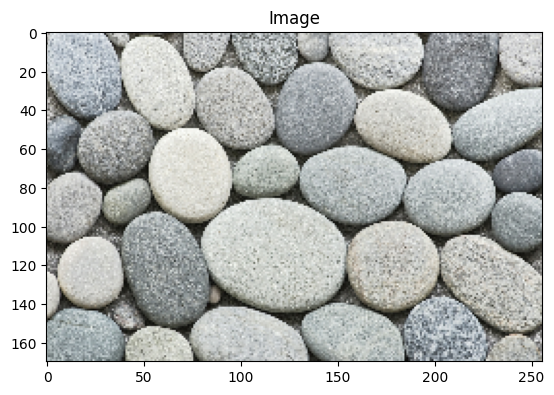

In [4]:
content_image = load_img(image_path, 256)
imshow(content_image, 'Image')
content_image.numpy().max(), content_image.numpy().shape # убедимся, что картинка нужного размера, а также значения 
                                                         # лежат в промежутке от 0 до 1

# Определяем функцию потерь и оптимизатор

In [5]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.5)

def loss(image):
    return tf.keras.losses.MeanSquaredError()(content_image, image)

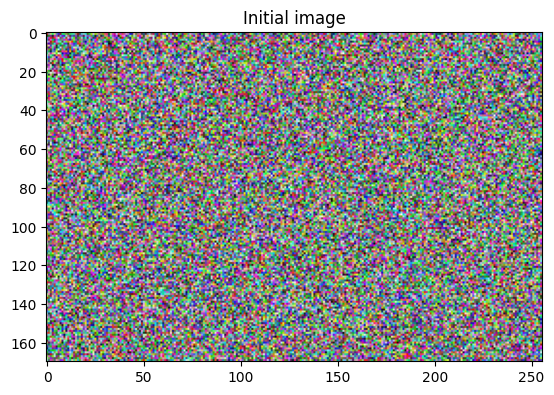

In [6]:
# image -- переменная , размепрм с исходную картинку, инициализированная случайно
image = tf.Variable(np.random.rand(*content_image.shape).astype(np.float32))
plt.figure()
imshow(image.numpy(), "Initial image")

# Теперь опишем шаг оптимизации, который должен каждый раз немного приближать нашу картинку к той, которая минимизирует функционал ошибки

In [7]:
def train_step(image, loss_func):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет нам полезна в дальнейшем.
    """
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    opt.apply_gradients([(grad, image)]) # шаг градиентного спуска в случае GD: image = image - lambda*dLoss/dImage
                                         # картинка после шага изменилась
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()
    
    

А теперь применим шаг train_step несколько раз к нашей картинке и посмотрим на промежуточные результаты:

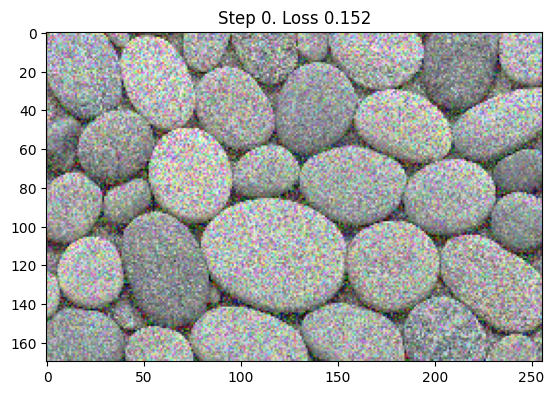

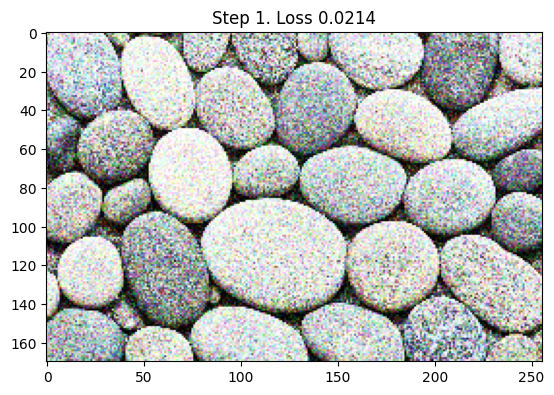

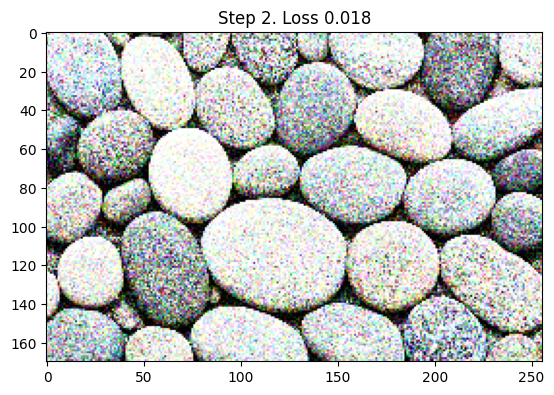

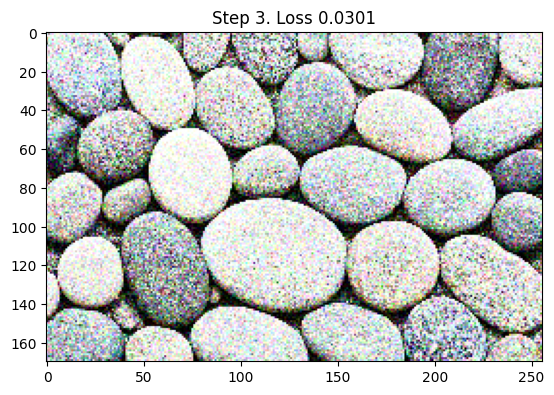

In [8]:
for i in range(4):
    loss_value = train_step(image, loss)
    plt.figure()
    imshow(image.read_value()[0], f"Step {i}. Loss {loss_value:.3}")